# New JIT and AOT Compilers

[John Stachurski](http://johnstachurski.net)

In [1]:
!pip install quantecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 9.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from numba import vectorize, jit, float64
from quantecon.util import tic, toc
import matplotlib.pyplot as plt

## Problem 1: A Time Series Model

Consider the time series model

$$ x_{t+1} = \alpha x_t (1 - x_t) $$

Let's set $\alpha = 4$

In [3]:
α = 4

Here's a typical time series:

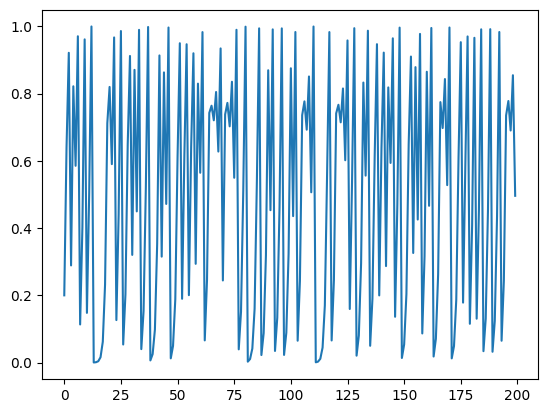

In [4]:
n = 200
x =  np.empty(n)
x[0] = 0.2
for t in range(n-1):
    x[t+1] = α * x[t] * (1 - x[t])
    
plt.plot(x)
plt.show()

## Python Test

Here's a function that simulates for `n` periods, starting from `x0`, and returns **only the final** value:

In [5]:
def quad(x0, n):
    x = x0
    for i in range(1, n):
        x = α * x * (1 - x)
    return x

Let's see how fast this runs:

In [6]:
n = 10_000_000

In [7]:
tic()
x = quad(0.2, n)
toc()

TOC: Elapsed: 0:00:2.39


2.3976573944091797

## Fortran Test

Now let's try this in Fortran.

Note --- this step is intended to be a demo and will only execute if

* you have the file `fastquad.f90` in your pwd
* you have a Fortran compiler installed and modify the compilation code below appropriately

In [8]:
%%file fortran_quad.f90

PURE FUNCTION QUAD(X0, N)
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                           
 REAL(dp), INTENT(IN) :: X0
 REAL(dp) :: QUAD
 INTEGER :: I
 INTEGER, INTENT(IN) :: N
 QUAD = X0
 DO I = 1, N - 1                                                
  QUAD = 4.0_dp * QUAD * real(1.0_dp - QUAD, dp)
 END DO
 RETURN
END FUNCTION QUAD

PROGRAM MAIN
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                          
 REAL(dp) :: START, FINISH, X, QUAD
 INTEGER :: N
 N = 10000000
 X = QUAD(0.2_dp, 10)
 CALL CPU_TIME(START)
 X = QUAD(0.2_dp, N)
 CALL CPU_TIME(FINISH)
 PRINT *,'last val = ', X
 PRINT *,'elapsed time = ', FINISH-START
END PROGRAM MAIN

Writing fortran_quad.f90


In [9]:
!gfortran -O3 fortran_quad.f90

In [10]:
!./a.out

 last val =   0.46200166384322749     
 elapsed time =    2.8689999999999997E-002


In [11]:
!rm a.out

## Python + Numba

Now let's do the same thing in Python using Numba's JIT compilation:

In [12]:
quad_jitted = jit(quad)

In [13]:
tic()
x = quad_jitted(0.2, n)
toc()

TOC: Elapsed: 0:00:0.09


0.09011554718017578

In [14]:
tic()
x = quad_jitted(0.2, n)
toc()

TOC: Elapsed: 0:00:0.02


0.025983333587646484

## Codon

In [15]:
!/bin/bash -c "$(curl -fsSL https://exaloop.io/install.sh)"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
codon-deploy/python/
codon-deploy/python/pyproject.toml
codon-deploy/python/codon_jit.egg-info/
codon-deploy/python/codon_jit.egg-info/requires.txt
codon-deploy/python/codon_jit.egg-info/PKG-INFO
codon-deploy/python/codon_jit.egg-info/dependency_links.txt
codon-deploy/python/codon_jit.egg-info/top_level.txt
codon-deploy/python/codon_jit.egg-info/SOURCES.txt
codon-deploy/python/setup.py
codon-deploy/python/README.md
codon-deploy/python/codon/
codon-deploy/python/codon/jit.pyx
codon-deploy/python/codon/jit.pxd
codon-deploy/python/codon/__init__.py
codon-deploy/python/codon/decorator.py
codon-deploy/python/codon/version.py
codon-deploy/python/MANIFEST.in
codon-deploy/python/.git

In [16]:
%%file codon_quad.py

from time import time

n = 10_000_000
alpha = 4.0

def quad(x0, n):
    x = x0
    for i in range(1, n):
        x = alpha * x * (1 - x)
    return x


t0 = time()
x = quad(0.1, n)
t1 = time()
print(x)
print(t1 - t0)

Writing codon_quad.py


In [21]:
!/root/.codon/bin/codon build --release --exe codon_quad.py

In [22]:
!./codon_quad

0.731205
0.0265207


In [23]:
!rm codon_quad